# Train a neural network for janken with Keras

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Force to use CPU for now
tf.config.set_visible_devices([], 'GPU')

## Create an input pipeline
### Load data

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

### Get the training dataset spec

In [4]:
ds_train_spec = tf.data.DatasetSpec.from_value(ds_train)
ds_train_spec

DatasetSpec((TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), TensorShape([]))

### Build the training pipeline

1. Scale and cast the `uint8` RGB codes to `float32` in `[0, 1]`.
2. Cache the data pre-shuffle (recommended when it fits in memory).
3. Shuffle.
4. Set up batches.
5. Prefetch (an apparent best practice for [performance reasons](https://www.tensorflow.org/guide/data_performance#prefetching)).

In [5]:
def recast(image, label):
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    return tf.image.random_flip_left_right(image), label

ds_train = ds_train.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(512)

ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Build the test pipeline

Note: caching is done after batching because batches can be the same between epochs?

In [6]:
ds_test = ds_test.map(
    recast,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create and train the model

In [7]:
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50V2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [8]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dropout (Dropout)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 20,023,619
Trainable params: 5,308,931
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
# import pathlib

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=pathlib.Path.cwd() / 'logs', profile_batch=0)
history = model.fit(ds_train, epochs=4, validation_data=ds_test)

Epoch 1/4
40/40 [==============================] - 1374s 34s/step - loss: 0.8950 - accuracy: 0.8778 - val_loss: 0.8937 - val_accuracy: 0.7715
Epoch 2/4
40/40 [==============================] - 1302s 33s/step - loss: 0.1356 - accuracy: 1.0000 - val_loss: 0.3544 - val_accuracy: 0.9167
Epoch 3/4
40/40 [==============================] - 1291s 32s/step - loss: 0.1036 - accuracy: 1.0000 - val_loss: 0.3831 - val_accuracy: 0.8952
Epoch 4/4
40/40 [==============================] - 1340s 34s/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.3775 - val_accuracy: 0.8952


## Review the history

In [12]:
import matplotlib.pyplot as plt

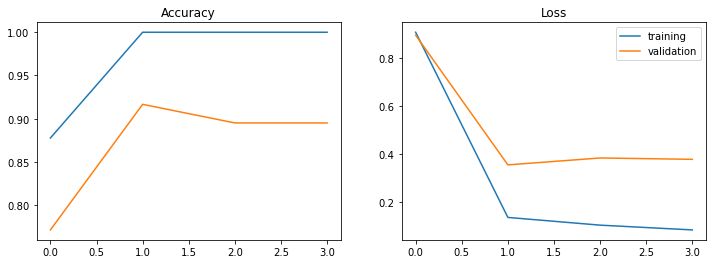

In [13]:
fig, (acc, los) = plt.subplots(1, 2, figsize=(12, 4))

acc.plot(history.epoch, history.history['accuracy'], label='training')
acc.plot(history.epoch, history.history['val_accuracy'], label='validation')
acc.set_title('Accuracy')
los.plot(history.epoch, history.history['loss'], label='training')
los.plot(history.epoch, history.history['val_loss'], label='validation')
los.set_title('Loss')
plt.legend(loc='best')

## Save the model

In [14]:
model.save('janken_take_4.h5')